In [48]:
import pandas as pd
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from difflib import get_close_matches
import requests
from sklearn.model_selection import TimeSeriesSplit

df = pd.read_csv("pga_data.csv")
df.head()

,Player_initial_last,tournament id,player id,hole_par,strokes,hole_DKP,hole_FDP,hole_SDP,streak_DKP,streak_FDP,streak_SDP,n_rounds,made_cut,pos,finish_DKP,finish_FDP,finish_SDP,total_DKP,total_FDP,total_SDP,player,Unnamed: 2,Unnamed: 3,Unnamed: 4,tournament name,course,date,purse,season,no_cut,Finish,sg_putt,sg_arg,sg_app,sg_ott,sg_t2g,sg_total
0,A. Ancer,401353224,9261,288,289,60.0,51.1,56,3,7.6,3,4,1,32.0,2,1,0,65.0,59.7,59,Abraham Ancer,NaN,NaN,NaN,The Memorial Tournament pres. by Nationwide,"Muirfield Village Golf Club - Dublin, OH",2022-06-05,12.0,2022,0,T32,0.20,-0.13,-0.08,0.86,0.65,0.85
1,A. Hadwin,401353224,5548,288,286,72.5,61.5,61,8,13.0,3,4,1,18.0,5,4,2,85.5,78.5,66,Adam Hadwin,NaN,NaN,NaN,The Memorial Tournament pres. by Nationwide,"Muirfield Village Golf Club - Dublin, OH",2022-06-05,12.0,2022,0,T18,0.36,0.75,0.31,0.18,1.24,1.60
2,A. Lahiri,401353224,4989,144,147,21.5,17.4,27,0,0.0,0,2,0,NaN,0,0,0,21.5,17.4,27,Anirban Lahiri,NaN,NaN,NaN,The Memorial Tournament pres. by Nationwide,"Muirfield Village Golf Club - Dublin, OH",2022-06-05,12.0,2022,0,CUT,-0.56,0.74,-1.09,0.37,0.02,-0.54
3,A. Long,401353224,6015,144,151,20.5,13.6,17,0,0.4,0,2,0,NaN,0,0,0,20.5,14.0,17,Adam Long,NaN,NaN,NaN,The Memorial Tournament pres. by Nationwide,"Muirfield Village Golf Club - Dublin, OH",2022-06-05,12.0,2022,0,CUT,-1.46,-1.86,-0.02,0.80,-1.08,-2.54
4,A. Noren,401353224,3832,144,148,23.5,18.1,23,0,1.2,0,2,0,NaN,0,0,0,23.5,19.3,23,Alexander Noren,NaN,NaN,NaN,The Memorial Tournament pres. by Nationwide,"Muirfield Village Golf Club - Dublin, OH",2022-06-05,12.0,2022,0,CUT,0.53,-0.36,-1.39,0.19,-1.56,-1.04


In [49]:
#fantasy stats, not necessary
df = df.drop(columns = ['hole_DKP', 'hole_FDP', 'hole_SDP', 'streak_DKP', 'streak_FDP', 'streak_SDP', 'finish_DKP', 'finish_FDP', 'finish_SDP', 'total_DKP', 'total_FDP', 'total_SDP'], errors = 'ignore')



In [50]:
#unnecessary identifiers or blanks
df = df.drop( columns = ['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4', 'player id', 'tournament id', 'Player_initial_last', 'n_rounds'], errors = 'ignore')


In [51]:
#possibly redundant or not predictive
df = df.drop(columns = ['tournament name', 'no_cut'], errors = 'ignore')


In [52]:
made_cut_only = pd.read_csv("pga_data.csv", usecols=['made_cut'])

# Re-add to your cleaned DataFrame
df['made_cut'] = made_cut_only

In [53]:
sg_columns = ['sg_putt', 'sg_arg', 'sg_app', 'sg_ott', 'sg_t2g', 'sg_total']
df = df.dropna(subset = sg_columns)


In [54]:
df = df[df['pos'].notna()]

In [55]:
df.loc[:, 'top5'] = (df['pos'] <= 5).astype(int)


In [56]:
df['course'].value_counts()

course
Muirfield Village Golf Club - Dublin, OH            630
Torrey Pines North - La Jolla, CA                   584
Harbour Town Golf Links - Hilton Head Island, SC    568
Pebble Beach Resort - Pebble Beach, CA              566
TPC Scottsdale - Scottsdale, AZ                     544
                                                   ... 
Vidanta Vallarta - Villa Hidalgo, Mexico             64
Congaree Golf Club - Ridgeland, SC                   63
Torrey Pines South - La Jolla, CA                    63
Winged Foot GC - Mamaroneck, NY                      58
Augusta National Golf Club - Augusta, GA             49
Name: count, Length: 69, dtype: int64

In [57]:
course_avg_sg = df.groupby('course')[sg_columns].mean()
course_avg_sg

df = df.merge(course_avg_sg, on='course', suffixes=('', '_course_avg'))
pd.set_option('display.max_columns', None)
df

,hole_par,strokes,made_cut,pos,player,course,date,purse,season,Finish,sg_putt,sg_arg,sg_app,sg_ott,sg_t2g,sg_total,top5,sg_putt_course_avg,sg_arg_course_avg,sg_app_course_avg,sg_ott_course_avg,sg_t2g_course_avg,sg_total_course_avg
0,288,289,1,32.0,Abraham Ancer,"Muirfield Village Golf Club - Dublin, OH",2022-06-05,12.0,2022,T32,0.20,-0.13,-0.08,0.86,0.65,0.85,0,0.233111,0.157968,0.337889,0.091063,0.587254,0.819698
1,288,286,1,18.0,Adam Hadwin,"Muirfield Village Golf Club - Dublin, OH",2022-06-05,12.0,2022,T18,0.36,0.75,0.31,0.18,1.24,1.60,0,0.233111,0.157968,0.337889,0.091063,0.587254,0.819698
2,288,287,1,26.0,Aaron Rai,"Muirfield Village Golf Club - Dublin, OH",2022-06-05,12.0,2022,T26,2.05,0.74,-1.32,-0.12,-0.70,1.35,0,0.233111,0.157968,0.337889,0.091063,0.587254,0.819698
3,288,287,1,26.0,Adam Schenk,"Muirfield Village Golf Club - Dublin, OH",2022-06-05,12.0,2022,T26,-0.96,-0.01,1.84,0.48,2.31,1.35,0,0.233111,0.157968,0.337889,0.091063,0.587254,0.819698
4,288,299,1,67.0,Adam Scott,"Muirfield Village Golf Club - Dublin, OH",2022-06-05,12.0,2022,T67,-0.82,-1.79,2.00,-1.04,-0.83,-1.65,0,0.233111,0.157968,0.337889,0.091063,0.587254,0.819698
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16286,284,277,1,49.0,Whee Kim,"TPC Summerlin - Las Vegas, NV",2014-10-19,6.2,2015,T49,0.66,-0.27,0.26,-0.39,-0.41,0.25,0,0.273943,0.119146,0.286321,0.111179,0.516646,0.789695
16287,284,275,1,33.0,William McGirt,"TPC Summerlin - Las Vegas, NV",2014-10-19,6.2,2015,T33,0.09,0.36,-0.37,0.66,0.66,0.75,0,0.273943,0.119146,0.286321,0.111179,0.516646,0.789695
16288,284,276,1,42.0,Wes Roach,"TPC Summerlin - Las Vegas, NV",2014-10-19,6.2,2015,T42,0.55,0.04,0.54,-0.64,-0.05,0.50,0,0.273943,0.119146,0.286321,0.111179,0.516646,0.789695
16289,284,269,1,4.0,Webb Simpson,"TPC Summerlin - Las Vegas, NV",2014-10-19,6.2,2015,T4,-0.02,0.76,1.23,0.28,2.27,2.25,1,0.273943,0.119146,0.286321,0.111179,0.516646,0.789695


In [58]:
df['sg_app_vs_course'] = df['sg_app'] - df['sg_app_course_avg']
df['sg_putt_vs_course'] = df['sg_putt'] - df['sg_putt_course_avg']
df['sg_arg_vs_course'] = df['sg_arg'] - df['sg_arg_course_avg']
df['sg_ott_vs_course'] = df['sg_ott'] - df['sg_ott_course_avg']
df['sg_t2g_vs_course'] = df['sg_t2g'] - df['sg_t2g_course_avg']
df['sg_total_vs_course'] = df['sg_total'] - df['sg_total_course_avg']
df

,hole_par,strokes,made_cut,pos,player,course,date,purse,season,Finish,sg_putt,sg_arg,sg_app,sg_ott,sg_t2g,sg_total,top5,sg_putt_course_avg,sg_arg_course_avg,sg_app_course_avg,sg_ott_course_avg,sg_t2g_course_avg,sg_total_course_avg,sg_app_vs_course,sg_putt_vs_course,sg_arg_vs_course,sg_ott_vs_course,sg_t2g_vs_course,sg_total_vs_course
0,288,289,1,32.0,Abraham Ancer,"Muirfield Village Golf Club - Dublin, OH",2022-06-05,12.0,2022,T32,0.20,-0.13,-0.08,0.86,0.65,0.85,0,0.233111,0.157968,0.337889,0.091063,0.587254,0.819698,-0.417889,-0.033111,-0.287968,0.768937,0.062746,0.030302
1,288,286,1,18.0,Adam Hadwin,"Muirfield Village Golf Club - Dublin, OH",2022-06-05,12.0,2022,T18,0.36,0.75,0.31,0.18,1.24,1.60,0,0.233111,0.157968,0.337889,0.091063,0.587254,0.819698,-0.027889,0.126889,0.592032,0.088937,0.652746,0.780302
2,288,287,1,26.0,Aaron Rai,"Muirfield Village Golf Club - Dublin, OH",2022-06-05,12.0,2022,T26,2.05,0.74,-1.32,-0.12,-0.70,1.35,0,0.233111,0.157968,0.337889,0.091063,0.587254,0.819698,-1.657889,1.816889,0.582032,-0.211063,-1.287254,0.530302
3,288,287,1,26.0,Adam Schenk,"Muirfield Village Golf Club - Dublin, OH",2022-06-05,12.0,2022,T26,-0.96,-0.01,1.84,0.48,2.31,1.35,0,0.233111,0.157968,0.337889,0.091063,0.587254,0.819698,1.502111,-1.193111,-0.167968,0.388937,1.722746,0.530302
4,288,299,1,67.0,Adam Scott,"Muirfield Village Golf Club - Dublin, OH",2022-06-05,12.0,2022,T67,-0.82,-1.79,2.00,-1.04,-0.83,-1.65,0,0.233111,0.157968,0.337889,0.091063,0.587254,0.819698,1.662111,-1.053111,-1.947968,-1.131063,-1.417254,-2.469698
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16286,284,277,1,49.0,Whee Kim,"TPC Summerlin - Las Vegas, NV",2014-10-19,6.2,2015,T49,0.66,-0.27,0.26,-0.39,-0.41,0.25,0,0.273943,0.119146,0.286321,0.111179,0.516646,0.789695,-0.026321,0.386057,-0.389146,-0.501179,-0.926646,-0.539695
16287,284,275,1,33.0,William McGirt,"TPC Summerlin - Las Vegas, NV",2014-10-19,6.2,2015,T33,0.09,0.36,-0.37,0.66,0.66,0.75,0,0.273943,0.119146,0.286321,0.111179,0.516646,0.789695,-0.656321,-0.183943,0.240854,0.548821,0.143354,-0.039695
16288,284,276,1,42.0,Wes Roach,"TPC Summerlin - Las Vegas, NV",2014-10-19,6.2,2015,T42,0.55,0.04,0.54,-0.64,-0.05,0.50,0,0.273943,0.119146,0.286321,0.111179,0.516646,0.789695,0.253679,0.276057,-0.079146,-0.751179,-0.566646,-0.289695
16289,284,269,1,4.0,Webb Simpson,"TPC Summerlin - Las Vegas, NV",2014-10-19,6.2,2015,T4,-0.02,0.76,1.23,0.28,2.27,2.25,1,0.273943,0.119146,0.286321,0.111179,0.516646,0.789695,0.943679,-0.293943,0.640854,0.168821,1.753354,1.460305


In [59]:
vs_course_cols = [
    'sg_putt_vs_course',
    'sg_arg_vs_course',
    'sg_app_vs_course',
    'sg_ott_vs_course',
    'sg_t2g_vs_course',
    'sg_total_vs_course'
]

player_course_fit = df.groupby(['player', 'course'])[vs_course_cols].mean()
player_course_fit


sg_putt_vs_course  \
player         course                                                      
Aaron Baddeley Baltusrol - Springfield, NJ                     -0.120135   
               Bay Hill - Orlando, FL                           0.376250   
               Colonial - Ft. Worth, TX                         1.092857   
               Congaree Golf Club - Ridgeland, SC               0.830476   
               Congressional - Bethesda, MD                     0.716892   
...                                                                  ...   
Zack Sucher    Trinity Forest Golf Club - Dallas, TX           -0.219143   
Zander Lombard Chapultepec - Mexico City, Mexico                1.045039   
Zecheng Dou    Pebble Beach Resort - Pebble Beach, CA           0.168534   
               TPC San Antonio - San Antonio, TX               -0.290977   
               TPC Southwind - Memphis, TN                     -0.982423   

                                                       sg_arg_vs_course  \
player         course                                                     
Aaron Baddeley Baltusrol - Springfield, NJ                     0.125541   
               Bay Hill - Orlando, FL                          1.618044   
               Colonial - Ft. Worth, TX                        0.214536   
               Congaree Golf Club - Ridgeland, SC              0.509683   
               Congressional - Bethesda, MD                   -0.612432   
...                                                                 ...   
Zack Sucher    Trinity Forest Golf Club - Dallas, TX          -0.441143   
Zander Lombard Chapultepec - Mexico City, Mexico              -0.879729   
Zecheng Dou    Pebble Beach Resort - Pebble Beach, CA         -0.785353   
               TPC San Antonio - San Antonio, TX              -0.171295   
               TPC Southwind - Memphis, TN                    -0.165551   

                                                       sg_app_vs_course  \
player         course                                                     
Aaron Baddeley Baltusrol - Springfield, NJ                    -0.252703   
               Bay Hill - Orlando, FL                         -0.504274   
               Colonial - Ft. Worth, TX                       -0.588786   
               Congaree Golf Club - Ridgeland, SC             -0.030476   
               Congressional - Bethesda, MD                    0.302297   
...                                                                 ...   
Zack Sucher    Trinity Forest Golf Club - Dallas, TX           0.354143   
Zander Lombard Chapultepec - Mexico City, Mexico               0.030930   
Zecheng Dou    Pebble Beach Resort - Pebble Beach, CA          2.049523   
               TPC San Antonio - San Antonio, TX              -0.852739   
               TPC Southwind - Memphis, TN                    -0.102137   

                                                       sg_ott_vs_course  \
player         course                                                     
Aaron Baddeley Baltusrol - Springfield, NJ                    -0.007162   
               Bay Hill - Orlando, FL                         -1.167984   
               Colonial - Ft. Worth, TX                       -1.415786   
               Congaree Golf Club - Ridgeland, SC             -1.657778   
               Congressional - Bethesda, MD                    0.462297   
...                                                                 ...   
Zack Sucher    Trinity Forest Golf Club - Dallas, TX           0.148500   
Zander Lombard Chapultepec - Mexico City, Mexico               0.159884   
Zecheng Dou    Pebble Beach Resort - Pebble Beach, CA         -0.193216   
               TPC San Antonio - San Antonio, TX               0.525945   
               TPC Southwind - Memphis, TN                     0.561982   

                                                       sg_t2g_vs_course  \
player         course                                          

In [60]:
features1 = ['sg_putt', 'sg_arg', 'sg_app', 'sg_ott', 'sg_t2g', 'sg_total']
df[features1 + ['pos']].corr()['pos'].sort_values()


sg_total   -0.704336
sg_t2g     -0.548726
sg_app     -0.390426
sg_putt    -0.350061
sg_ott     -0.304706
sg_arg     -0.234263
pos         1.000000
Name: pos, dtype: float64

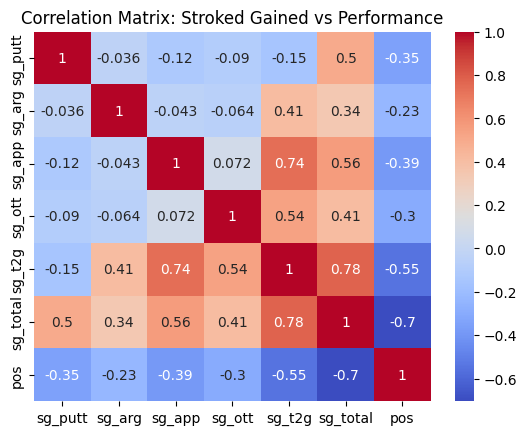

In [61]:
sns.heatmap(df[features1 + ['pos']].corr(), annot = True, cmap = 'coolwarm')
plt.title("Correlation Matrix: Stroked Gained vs Performance")
plt.show()

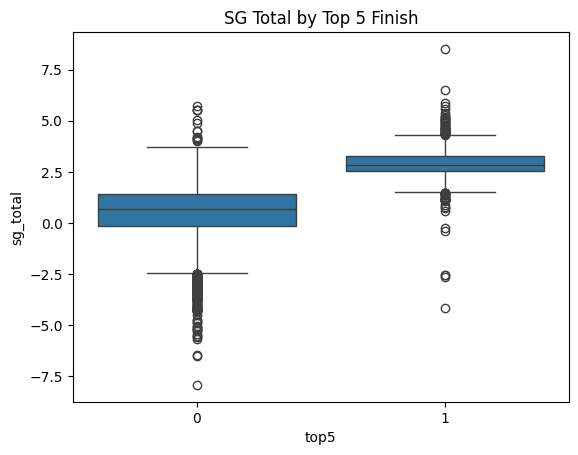

In [62]:
sns.boxplot(x='top5', y='sg_total', data=df)
plt.title("SG Total by Top 5 Finish")
plt.show()

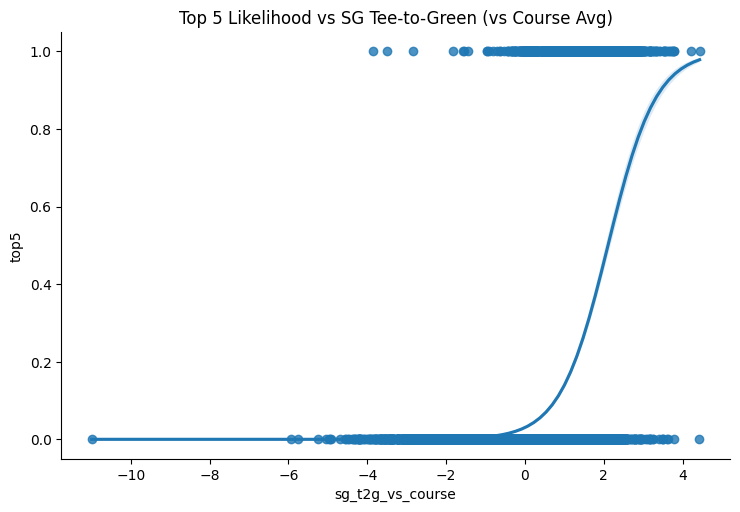

In [63]:
sns.lmplot(data=df, x='sg_t2g_vs_course', y='top5', logistic=True, height=5, aspect=1.5)
plt.title("Top 5 Likelihood vs SG Tee-to-Green (vs Course Avg)")
plt.show()

In [64]:
features_vs_avg = [
    'sg_putt_vs_course', 'sg_arg_vs_course', 'sg_app_vs_course',
    'sg_ott_vs_course'
]

X = df[features_vs_avg]
y = df['top5']

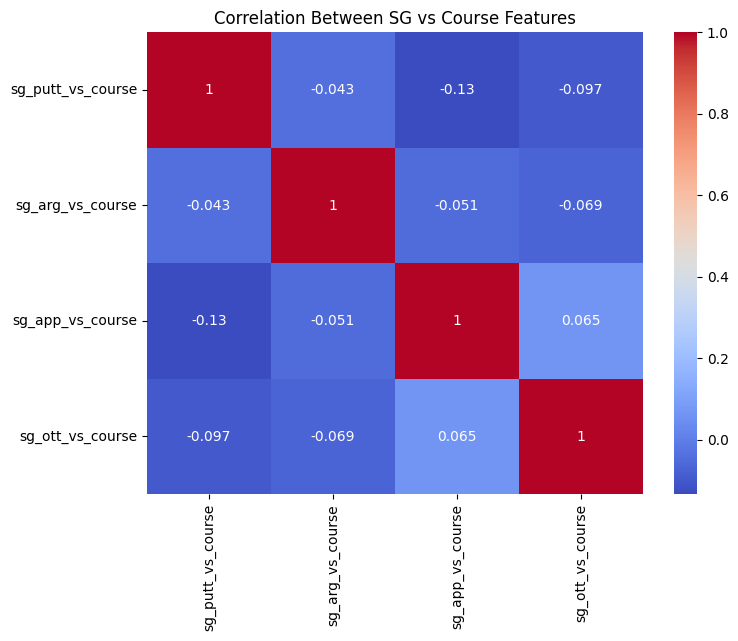

In [65]:
plt.figure(figsize=(8,6))
sns.heatmap(X.corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Between SG vs Course Features")
plt.show()

In [66]:
X_const = add_constant(X)
vif_data = pd.DataFrame()
vif_data["Feature"] = X_const.columns
vif_data["VIF"] = [variance_inflation_factor(X_const.values, i) for i in range(X_const.shape[1])]
print(vif_data)

             Feature       VIF
0              const  1.000000
1  sg_putt_vs_course  1.029732
2   sg_arg_vs_course  1.010356
3   sg_app_vs_course  1.023953
4   sg_ott_vs_course  1.017461


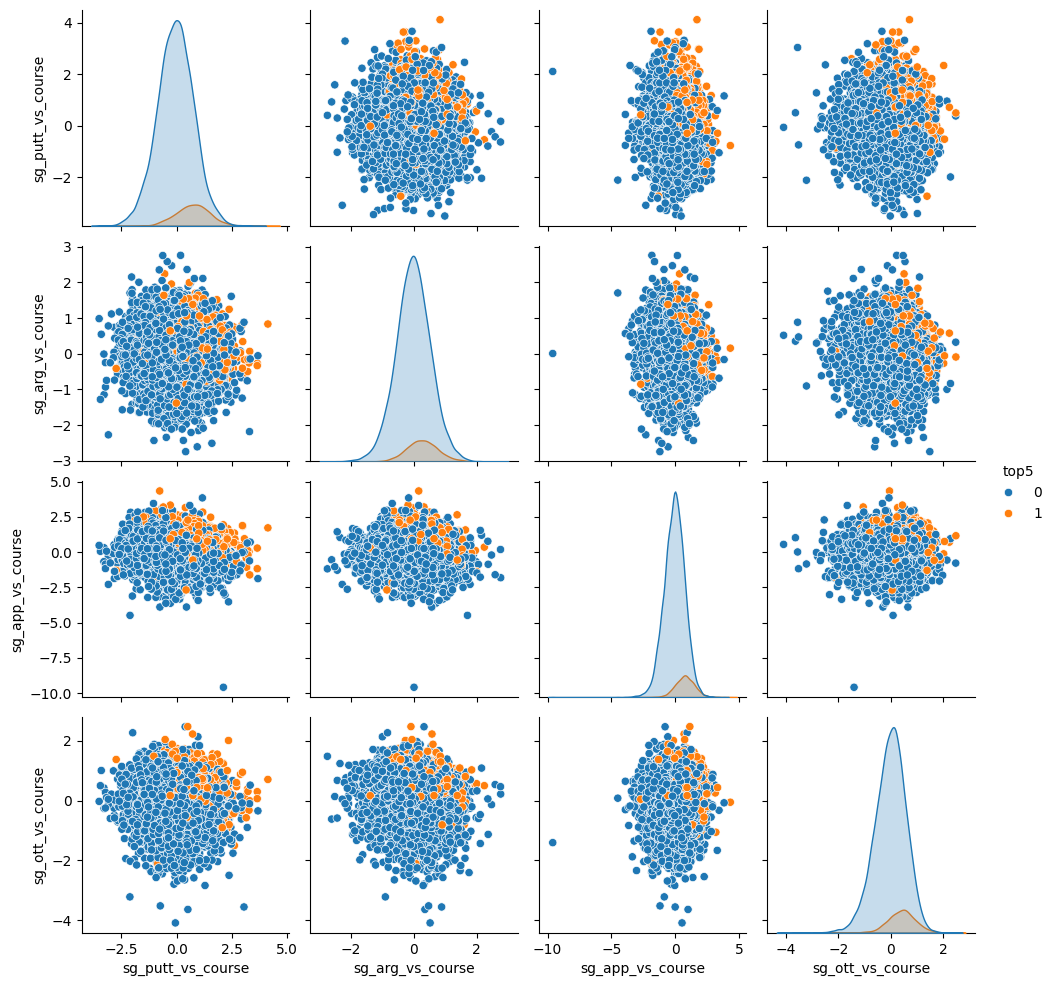

In [67]:
sns.pairplot(df[features_vs_avg + ['top5']], hue='top5')

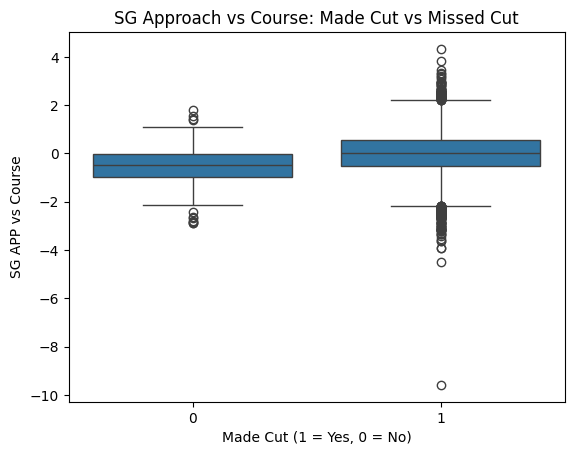

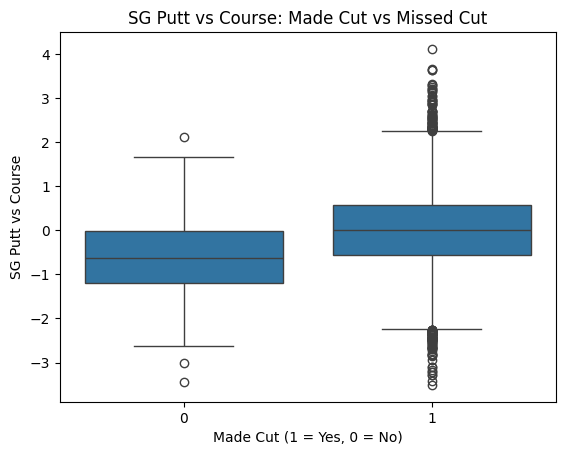

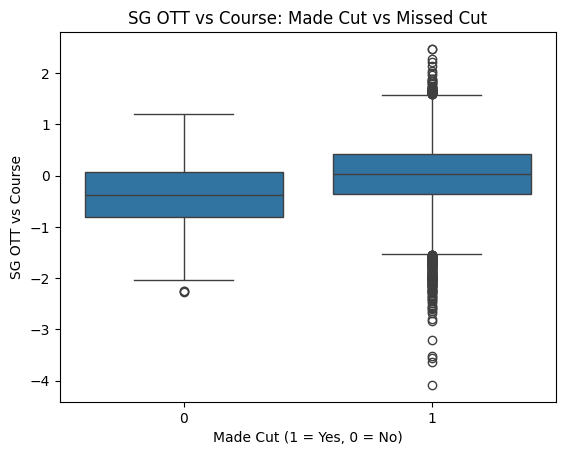

In [68]:
sns.boxplot(x='made_cut', y='sg_app_vs_course', data=df)
plt.title("SG Approach vs Course: Made Cut vs Missed Cut")
plt.xlabel("Made Cut (1 = Yes, 0 = No)")
plt.ylabel("SG APP vs Course")
plt.show()

sns.boxplot(x='made_cut', y='sg_putt_vs_course', data=df)
plt.title("SG Putt vs Course: Made Cut vs Missed Cut")
plt.xlabel("Made Cut (1 = Yes, 0 = No)")
plt.ylabel("SG Putt vs Course")
plt.show()

sns.boxplot(x='made_cut', y='sg_ott_vs_course', data=df)
plt.title("SG OTT vs Course: Made Cut vs Missed Cut")
plt.xlabel("Made Cut (1 = Yes, 0 = No)")
plt.ylabel("SG OTT vs Course")
plt.show()

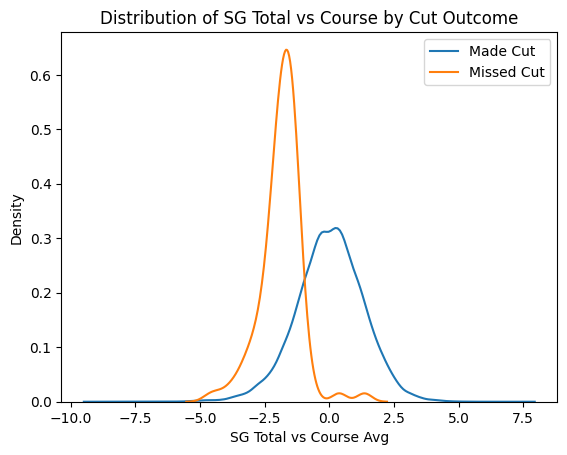

In [69]:
sns.kdeplot(df[df['made_cut'] == 1]['sg_total_vs_course'], label='Made Cut')
sns.kdeplot(df[df['made_cut'] == 0]['sg_total_vs_course'], label='Missed Cut')
plt.title("Distribution of SG Total vs Course by Cut Outcome")
plt.xlabel("SG Total vs Course Avg")
plt.legend()
plt.show()

In [70]:
sg_features = [
    'sg_putt_vs_course',
    'sg_arg_vs_course',
    'sg_app_vs_course',
    'sg_ott_vs_course'
]

# Subset only players who made the cut
cut_df = df[df['made_cut'] == 1]

# Group by tournament and calculate average SG stats
cut_sg_by_course = cut_df.groupby('course')[sg_features].mean()


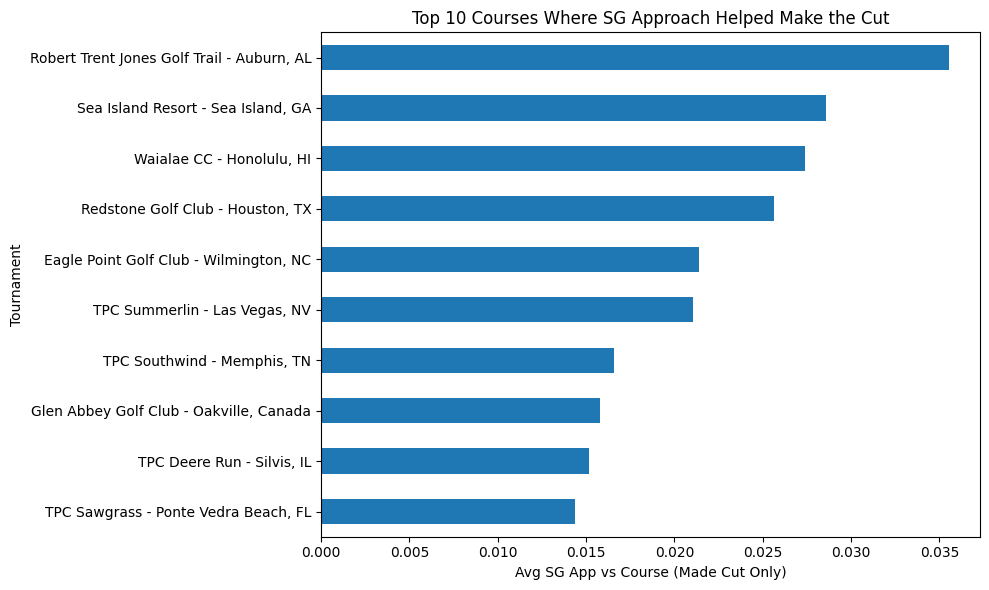

In [71]:
# 1. Subset only made cut + non-missing sg_app_vs_course
cut_df = df[(df['made_cut'] == 1) & (df['sg_app_vs_course'].notna())]

# 2. Count how many players made the cut at each course
cut_counts = cut_df['course'].value_counts()

# 3. Filter to tournaments with at least 20 made cuts
valid_courses = cut_counts[cut_counts >= 20].index
cut_df_clean = cut_df[cut_df['course'].isin(valid_courses)]

# 4. Group by tournament and take average of SG App vs Course
sg_app_by_course = cut_df_clean.groupby('course')['sg_app_vs_course'].mean()

# 5. Sort and grab top 10 tournaments
top10_courses = sg_app_by_course.sort_values(ascending=False).head(10)

# 6. Plot it
plt.figure(figsize=(10, 6))
top10_courses.plot(kind='barh')
plt.title("Top 10 Courses Where SG Approach Helped Make the Cut")
plt.xlabel("Avg SG App vs Course (Made Cut Only)")
plt.ylabel("Tournament")
plt.gca().invert_yaxis()  # So the best is at the top
plt.tight_layout()
plt.show()

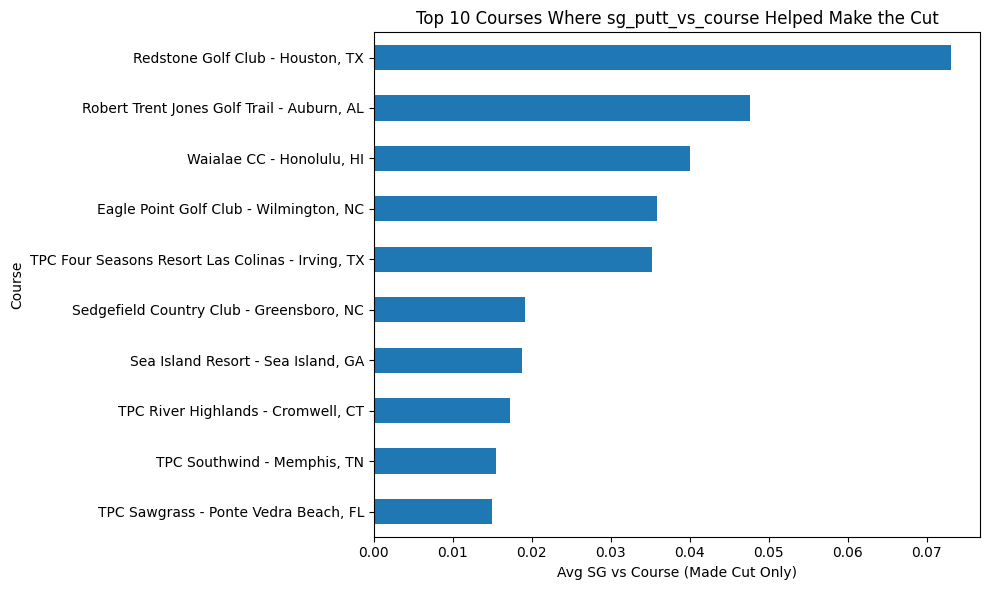

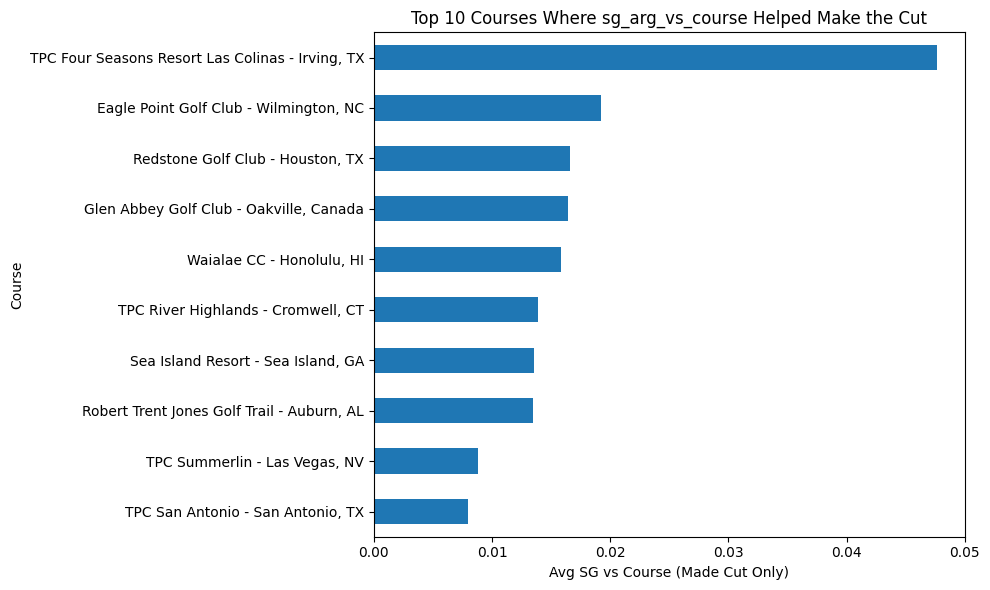

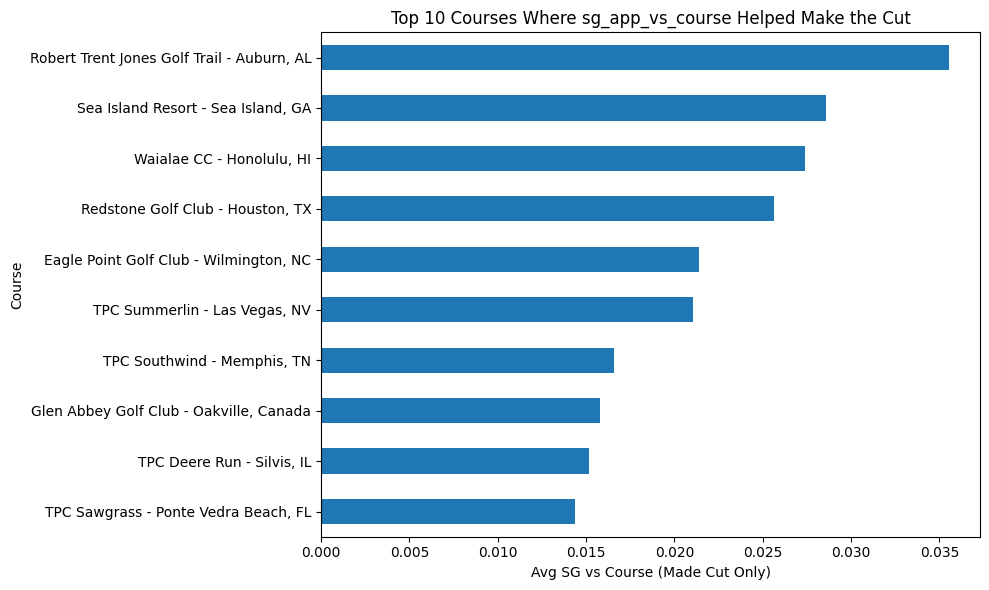

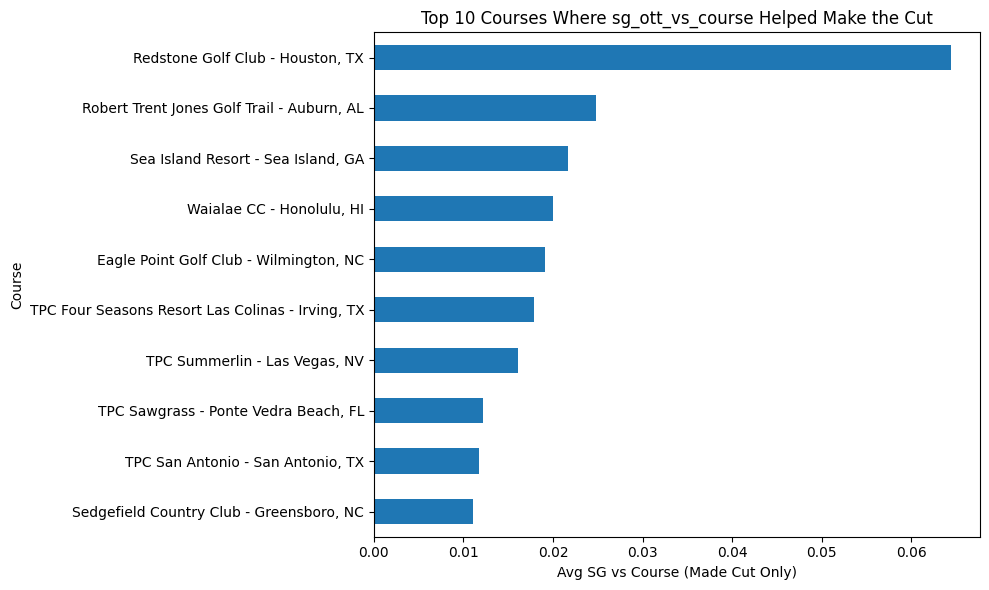

In [72]:
cut_df = df[df['made_cut'] == 1].copy()

# Filter out tournaments with too few players (e.g., < 20)
valid_tournaments = cut_df['course'].value_counts()
valid_tournaments = valid_tournaments[valid_tournaments >= 20].index
cut_df = cut_df[cut_df['course'].isin(valid_tournaments)]

# Loop through each SG feature and plot
for feature in sg_features:
    # Drop NaNs for current feature
    clean_df = cut_df[cut_df[feature].notna()]
    
    # Group by tournament and compute mean SG for that feature
    sg_by_course = clean_df.groupby('course')[feature].mean()
    
    # Get top 10 courses where this SG feature contributed most to making the cut
    top10 = sg_by_course.sort_values(ascending=False).head(10)
    
    # Plot
    plt.figure(figsize=(10, 6))
    top10.plot(kind='barh')
    plt.title(f"Top 10 Courses Where {feature} Helped Make the Cut")
    plt.xlabel("Avg SG vs Course (Made Cut Only)")
    plt.ylabel("Course")
    plt.gca().invert_yaxis()  # Best course at the top
    plt.tight_layout()
    plt.show()

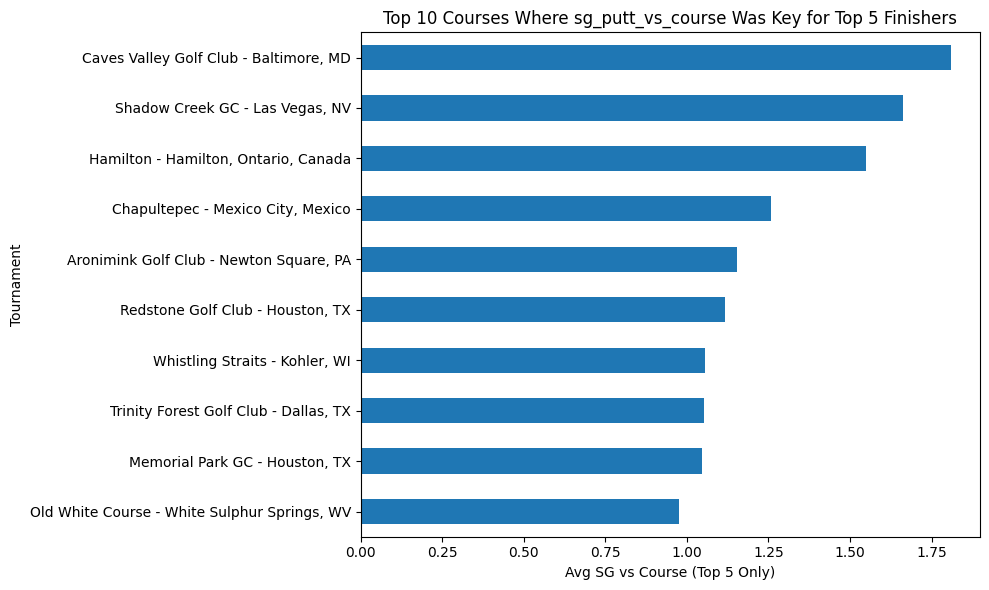

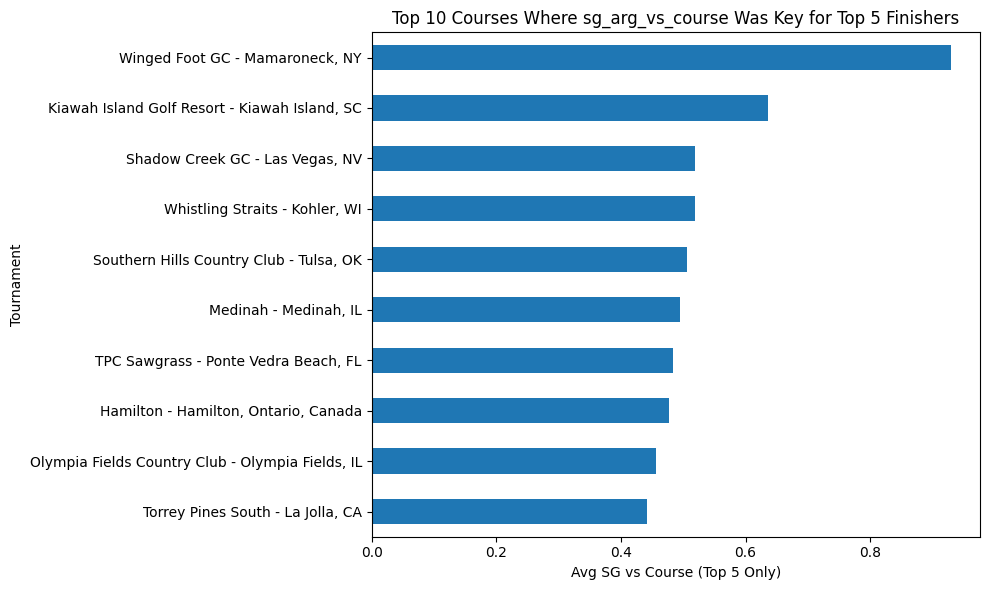

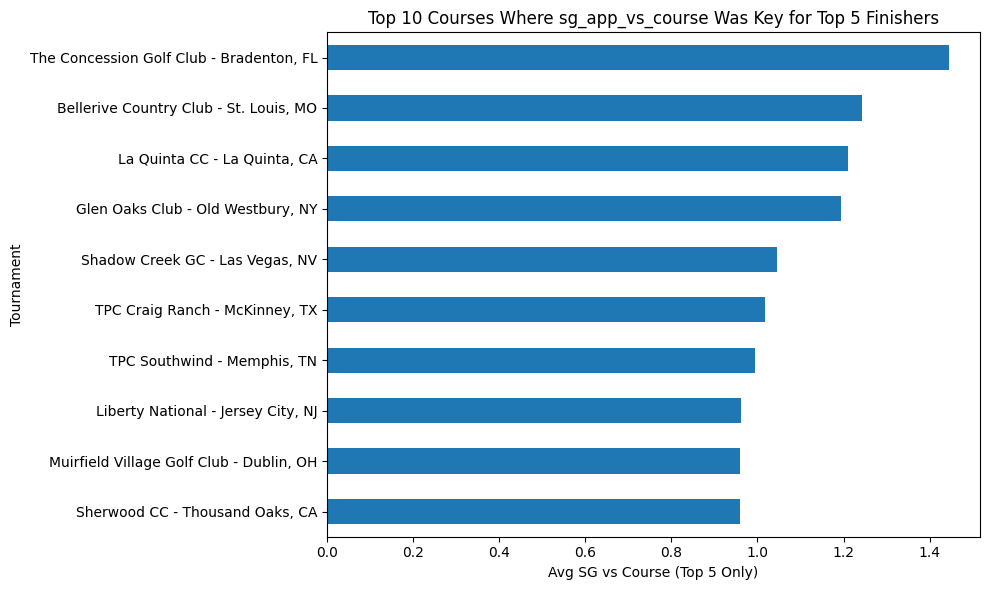

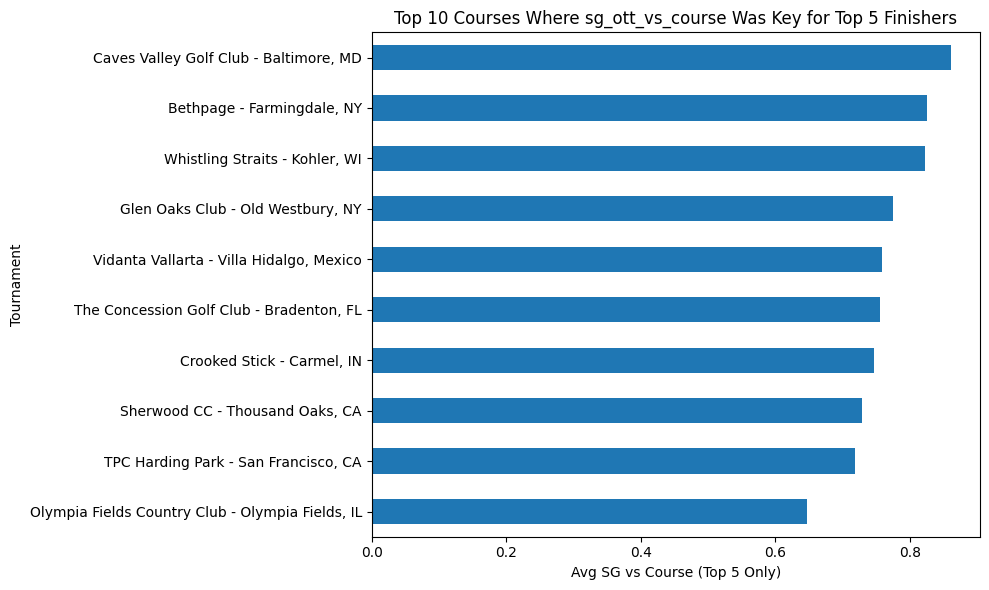

In [73]:
# Filter: only players who finished in the Top 5 and have valid tournament info
top5_df = df[df['top5'] == 1].copy()

# Filter out tournaments with too few Top 5 finishers (e.g., < 5 to avoid noise)
valid_top5_tournaments = top5_df['course'].value_counts()
valid_top5_tournaments = valid_top5_tournaments[valid_top5_tournaments >= 5].index
top5_df = top5_df[top5_df['course'].isin(valid_top5_tournaments)]

# Loop through each SG feature and plot Top 10 courses
for feature in sg_features:
    # Remove missing values
    clean_df = top5_df[top5_df[feature].notna()]
    
    # Group by tournament and calculate mean SG stat for Top 5 finishers
    sg_by_course = clean_df.groupby('course')[feature].mean()
    
    # Take Top 10 courses where this SG stat was highest
    top10 = sg_by_course.sort_values(ascending=False).head(10)
    
    # Plot
    plt.figure(figsize=(10, 6))
    top10.plot(kind='barh')
    plt.title(f"Top 10 Courses Where {feature} Was Key for Top 5 Finishers")
    plt.xlabel("Avg SG vs Course (Top 5 Only)")
    plt.ylabel("Tournament")
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

In [74]:
course_data = pd.read_csv("Course_Tier_Data.csv")
course_data = course_data.set_index('course')
course_data = course_data.add_prefix("course_")
course_data

,course_is_long,course_is_short,course_fast_greens,course_is_penal,course_is_narrow,course_is_rough,course_is_target,course_is_altitude,course_is_windy,course_is_coastal
course,,,,,,,,,,
"Aronimink Golf Club - Newton Square, PA",1,0,1,1,1,1,0,0,0,0
"Augusta National Golf Club - Augusta, GA",1,0,1,1,0,0,0,0,0,0
"Baltusrol - Springfield, NJ",1,0,1,1,1,1,0,0,0,0
"Bay Hill - Orlando, FL",1,0,1,1,1,1,0,0,1,0
"Bellerive Country Club - St. Louis, MO",1,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
"Trinity Forest Golf Club - Dallas, TX",0,0,0,0,0,0,0,0,0,0
"Vidanta Vallarta - Villa Hidalgo, Mexico",0,0,0,0,0,0,0,0,0,0
"Waialae CC - Honolulu, HI",0,0,0,0,0,0,0,0,0,0


In [75]:
merged_df = pd.merge(
    left = df,
    right = course_data,
    how = 'left',
    left_on = 'course',
    right_on = 'course'
)
merged_df = merged_df.set_index('player')
merged_df = merged_df.drop(columns = ['purse', 'course_is_penal'], errors = 'ignore')
merged_df

,hole_par,strokes,made_cut,pos,course,date,season,Finish,sg_putt,sg_arg,sg_app,sg_ott,sg_t2g,sg_total,top5,sg_putt_course_avg,sg_arg_course_avg,sg_app_course_avg,sg_ott_course_avg,sg_t2g_course_avg,sg_total_course_avg,sg_app_vs_course,sg_putt_vs_course,sg_arg_vs_course,sg_ott_vs_course,sg_t2g_vs_course,sg_total_vs_course,course_is_long,course_is_short,course_fast_greens,course_is_narrow,course_is_rough,course_is_target,course_is_altitude,course_is_windy,course_is_coastal
player,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Abraham Ancer,288,289,1,32.0,"Muirfield Village Golf Club - Dublin, OH",2022-06-05,2022,T32,0.20,-0.13,-0.08,0.86,0.65,0.85,0,0.233111,0.157968,0.337889,0.091063,0.587254,0.819698,-0.417889,-0.033111,-0.287968,0.768937,0.062746,0.030302,0,0,0,0,0,0,0,0,0
Adam Hadwin,288,286,1,18.0,"Muirfield Village Golf Club - Dublin, OH",2022-06-05,2022,T18,0.36,0.75,0.31,0.18,1.24,1.60,0,0.233111,0.157968,0.337889,0.091063,0.587254,0.819698,-0.027889,0.126889,0.592032,0.088937,0.652746,0.780302,0,0,0,0,0,0,0,0,0
Aaron Rai,288,287,1,26.0,"Muirfield Village Golf Club - Dublin, OH",2022-06-05,2022,T26,2.05,0.74,-1.32,-0.12,-0.70,1.35,0,0.233111,0.157968,0.337889,0.091063,0.587254,0.819698,-1.657889,1.816889,0.582032,-0.211063,-1.287254,0.530302,0,0,0,0,0,0,0,0,0
Adam Schenk,288,287,1,26.0,"Muirfield Village Golf Club - Dublin, OH",2022-06-05,2022,T26,-0.96,-0.01,1.84,0.48,2.31,1.35,0,0.233111,0.157968,0.337889,0.091063,0.587254,0.819698,1.502111,-1.193111,-0.167968,0.388937,1.722746,0.530302,0,0,0,0,0,0,0,0,0
Adam Scott,288,299,1,67.0,"Muirfield Village Golf Club - Dublin, OH",2022-06-05,2022,T67,-0.82,-1.79,2.00,-1.04,-0.83,-1.65,0,0.233111,0.157968,0.337889,0.091063,0.587254,0.819698,1.662111,-1.053111,-1.947968,-1.131063,-1.417254,-2.469698,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Whee Kim,284,277,1,49.0,"TPC Summerlin - Las Vegas, NV",2014-10-19,2015,T49,0.66,-0.27,0.26,-0.39,-0.41,0.25,0,0.273943,0.119146,0.286321,0.111179,0.516646,0.789695,-0.026321,0.386057,-0.389146,-0.501179,-0.926646,-0.539695,1,0,1,0,1,0,0,0,0
William McGirt,284,275,1,33.0,"TPC Summerlin - Las Vegas, NV",2014-10-19,2015,T33,0.09,0.36,-0.37,0.66,0.66,0.75,0,0.273943,0.119146,0.286321,0.111179,0.516646,0.789695,-0.656321,-0.183943,0.240854,0.548821,0.143354,-0.039695,1,0,1,0,1,0,0,0,0
Wes Roach,284,276,1,42.0,"TPC Summerlin - Las Vegas, NV",2014-10-19,2015,T42,0.55,0.04,0.54,-0.64,-0.05,0.50,0,0.273943,0.119146,0.286321,0.111179,0.516646,0.789695,0.253679,0.276057,-0.079146,-0.751179,-0.566646,-0.289695,1,0,1,0,1,0,0,0,0


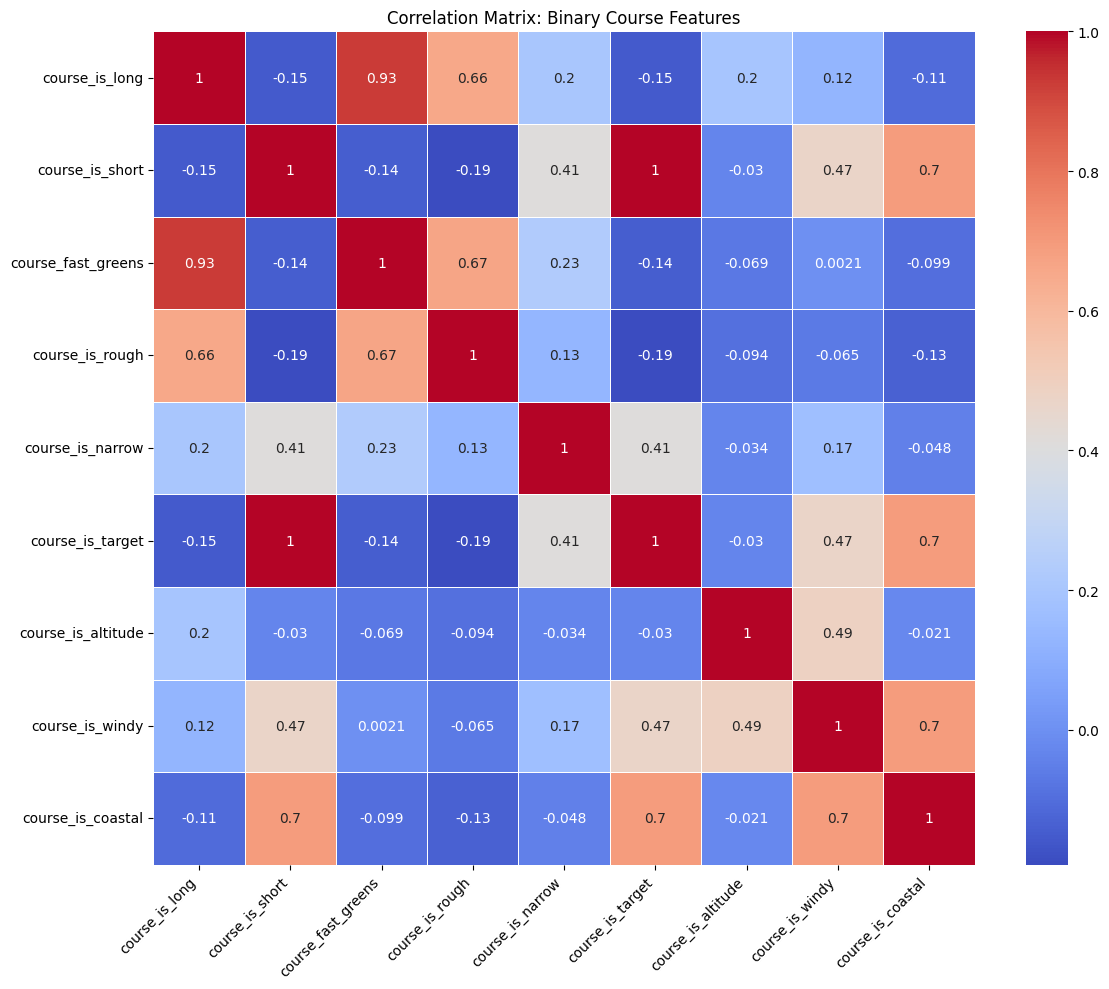

In [76]:
binary_features = ['course_is_long', 'course_is_short', 'course_fast_greens', 'course_is_rough', 'course_is_narrow', 'course_is_target', 'course_is_altitude', 'course_is_windy', 'course_is_coastal']

course_corr = course_data[binary_features].corr()
plt.figure(figsize=(12, 10))
sns.heatmap(course_corr, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title("Correlation Matrix: Binary Course Features")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [77]:
both_long_fast = course_data[
    (course_data['course_is_long'] == 1) & 
    (course_data['course_fast_greens'] == 1)
]

print(f"Number of courses that are both long and have fast greens: {len(both_long_fast)}")
display(both_long_fast[['course_is_long', 'course_fast_greens']])

Number of courses that are both long and have fast greens: 17


,course_is_long,course_fast_greens
course,,
"Aronimink Golf Club - Newton Square, PA",1,1
"Augusta National Golf Club - Augusta, GA",1,1
"Baltusrol - Springfield, NJ",1,1
"Bay Hill - Orlando, FL",1,1
"TPC Boston - Norton, MA",1,1
"TPC Craig Ranch - McKinney, TX",1,1
"TPC Deere Run - Silvis, IL",1,1
"TPC Four Seasons Resort Las Colinas - Irving, TX",1,1
"TPC Harding Park - San Francisco, CA",1,1


In [78]:
merged_df['top10'] = (merged_df['pos'] <= 10).astype(int)
merged_df['top20'] = (merged_df['pos'] <= 20).astype(int)
merged_df

,hole_par,strokes,made_cut,pos,course,date,season,Finish,sg_putt,sg_arg,sg_app,sg_ott,sg_t2g,sg_total,top5,sg_putt_course_avg,sg_arg_course_avg,sg_app_course_avg,sg_ott_course_avg,sg_t2g_course_avg,sg_total_course_avg,sg_app_vs_course,sg_putt_vs_course,sg_arg_vs_course,sg_ott_vs_course,sg_t2g_vs_course,sg_total_vs_course,course_is_long,course_is_short,course_fast_greens,course_is_narrow,course_is_rough,course_is_target,course_is_altitude,course_is_windy,course_is_coastal,top10,top20
player,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Abraham Ancer,288,289,1,32.0,"Muirfield Village Golf Club - Dublin, OH",2022-06-05,2022,T32,0.20,-0.13,-0.08,0.86,0.65,0.85,0,0.233111,0.157968,0.337889,0.091063,0.587254,0.819698,-0.417889,-0.033111,-0.287968,0.768937,0.062746,0.030302,0,0,0,0,0,0,0,0,0,0,0
Adam Hadwin,288,286,1,18.0,"Muirfield Village Golf Club - Dublin, OH",2022-06-05,2022,T18,0.36,0.75,0.31,0.18,1.24,1.60,0,0.233111,0.157968,0.337889,0.091063,0.587254,0.819698,-0.027889,0.126889,0.592032,0.088937,0.652746,0.780302,0,0,0,0,0,0,0,0,0,0,1
Aaron Rai,288,287,1,26.0,"Muirfield Village Golf Club - Dublin, OH",2022-06-05,2022,T26,2.05,0.74,-1.32,-0.12,-0.70,1.35,0,0.233111,0.157968,0.337889,0.091063,0.587254,0.819698,-1.657889,1.816889,0.582032,-0.211063,-1.287254,0.530302,0,0,0,0,0,0,0,0,0,0,0
Adam Schenk,288,287,1,26.0,"Muirfield Village Golf Club - Dublin, OH",2022-06-05,2022,T26,-0.96,-0.01,1.84,0.48,2.31,1.35,0,0.233111,0.157968,0.337889,0.091063,0.587254,0.819698,1.502111,-1.193111,-0.167968,0.388937,1.722746,0.530302,0,0,0,0,0,0,0,0,0,0,0
Adam Scott,288,299,1,67.0,"Muirfield Village Golf Club - Dublin, OH",2022-06-05,2022,T67,-0.82,-1.79,2.00,-1.04,-0.83,-1.65,0,0.233111,0.157968,0.337889,0.091063,0.587254,0.819698,1.662111,-1.053111,-1.947968,-1.131063,-1.417254,-2.469698,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Whee Kim,284,277,1,49.0,"TPC Summerlin - Las Vegas, NV",2014-10-19,2015,T49,0.66,-0.27,0.26,-0.39,-0.41,0.25,0,0.273943,0.119146,0.286321,0.111179,0.516646,0.789695,-0.026321,0.386057,-0.389146,-0.501179,-0.926646,-0.539695,1,0,1,0,1,0,0,0,0,0,0
William McGirt,284,275,1,33.0,"TPC Summerlin - Las Vegas, NV",2014-10-19,2015,T33,0.09,0.36,-0.37,0.66,0.66,0.75,0,0.273943,0.119146,0.286321,0.111179,0.516646,0.789695,-0.656321,-0.183943,0.240854,0.548821,0.143354,-0.039695,1,0,1,0,1,0,0,0,0,0,0
Wes Roach,284,276,1,42.0,"TPC Summerlin - Las Vegas, NV",2014-10-19,2015,T42,0.55,0.04,0.54,-0.64,-0.05,0.50,0,0.273943,0.119146,0.286321,0.111179,0.516646,0.789695,0.253679,0.276057,-0.079146,-0.751179,-0.566646,-0.289695,1,0,1,0,1,0,0,0,0,0,0


In [79]:
merged_df.to_csv("merged_df.csv")
type(merged_df)

pandas.core.frame.DataFrame

In [80]:
features = [
    'sg_putt_vs_course', 'sg_arg_vs_course',
    'sg_app_vs_course', 'sg_ott_vs_course',
    
    'course_is_long', 'course_is_short', 'course_fast_greens',
    'course_is_narrow', 'course_is_rough', 'course_is_altitude', 'course_is_windy'
]

merged_df['date'] = pd.to_datetime(merged_df['date'])

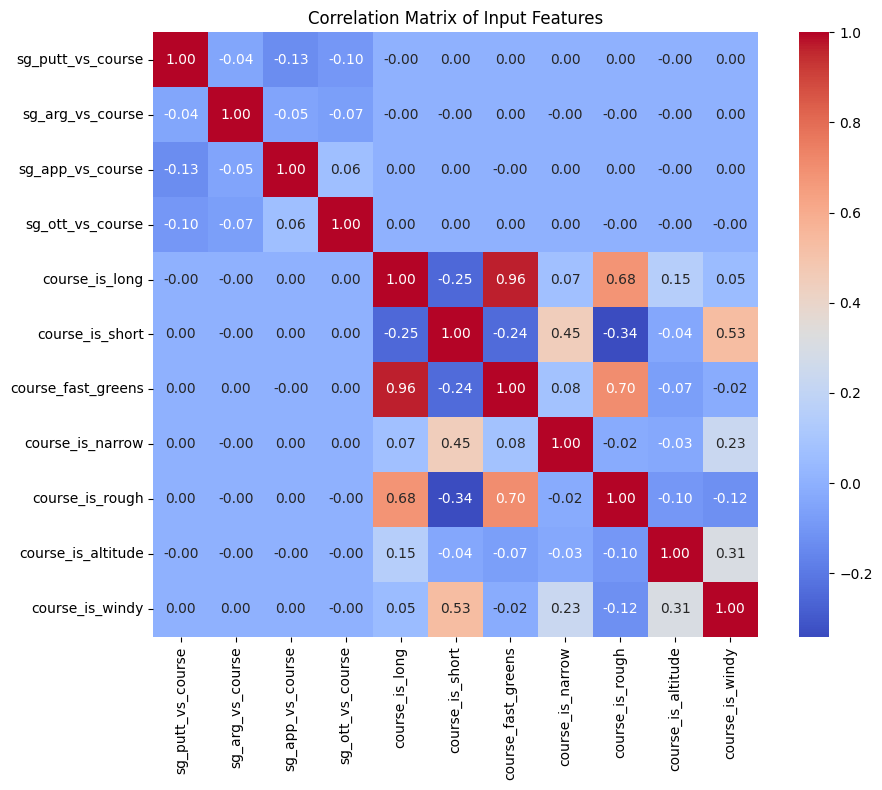

In [81]:
# Compute and plot correlation matrix
corr_matrix = merged_df[features].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", square=True)
plt.title("Correlation Matrix of Input Features")
plt.tight_layout()
plt.show()

In [82]:
# Optional: Drop any rows with NaNs in selected features
vif_df = merged_df[features].dropna().copy()

# Add constant for statsmodels
X_vif = add_constant(vif_df)

# Calculate VIF scores
vif_data = pd.DataFrame()
vif_data["feature"] = X_vif.columns
vif_data["VIF"] = [variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])]

# Display sorted VIFs (excluding the constant)
print(vif_data.sort_values(by="VIF", ascending=False))

               feature        VIF
5       course_is_long  48.427086
7   course_fast_greens  46.604573
10  course_is_altitude   3.606909
0                const   2.469624
9      course_is_rough   2.159721
6      course_is_short   2.063847
11     course_is_windy   1.689103
8     course_is_narrow   1.315866
1    sg_putt_vs_course   1.029732
3     sg_app_vs_course   1.023953
4     sg_ott_vs_course   1.017461
2     sg_arg_vs_course   1.010356


In [83]:
from sklearn.model_selection import StratifiedKFold, KFold, GridSearchCV
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, mean_squared_error, r2_score

In [84]:

# Sort by date before feature selection
merged_df = merged_df.sort_values(by='date')

# STEP 2: Define Features & Prepare Matrices
features = [
    'sg_putt_vs_course', 'sg_arg_vs_course', 'sg_app_vs_course', 'sg_ott_vs_course',
    'course_is_long', 'course_is_short', 'course_fast_greens',
    'course_is_narrow', 'course_is_rough', 'course_is_altitude', 'course_is_windy'
]

# Drop rows with NaNs in features
model_features = merged_df[features].dropna()

# Align targets
target_top5 = merged_df.loc[model_features.index, 'top5']
target_top10 = merged_df.loc[model_features.index, 'top10']
target_top20 = merged_df.loc[model_features.index, 'top20']



# Initialize XGBoost Model
def init_model():
    return XGBClassifier(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=4,
        subsample=0.8,
        colsample_bytree=0.8,
        eval_metric='logloss',
        random_state=42,
        use_label_encoder=False
    )

model_top5 = init_model()
model_top10 = init_model()
model_top20 = init_model()

tscv = TimeSeriesSplit(n_splits=7)

roc_scores_top5 = []
roc_scores_top10 = []
roc_scores_top20 = []

for train_idx, test_idx in tscv.split(model_features):
    X_train, X_test = model_features.iloc[train_idx], model_features.iloc[test_idx]
    y5_train, y5_test = target_top5.iloc[train_idx], target_top5.iloc[test_idx]
    y10_train, y10_test = target_top10.iloc[train_idx], target_top10.iloc[test_idx]
    y20_train, y20_test = target_top20.iloc[train_idx], target_top20.iloc[test_idx]

    # Train models
    model_top5.fit(X_train, y5_train)
    model_top10.fit(X_train, y10_train)
    model_top20.fit(X_train, y20_train)

    # Predict & calculate ROC-AUC
    prob5 = model_top5.predict_proba(X_test)[:, 1]
    prob10 = model_top10.predict_proba(X_test)[:, 1]
    prob20 = model_top20.predict_proba(X_test)[:, 1]

    roc_scores_top5.append(roc_auc_score(y5_test, prob5))
    roc_scores_top10.append(roc_auc_score(y10_test, prob10))
    roc_scores_top20.append(roc_auc_score(y20_test, prob20))

print(f"Top 5 ROC-AUC (avg): {np.mean(roc_scores_top5):.3f}")
print(f"Top 10 ROC-AUC (avg): {np.mean(roc_scores_top10):.3f}")
print(f"Top 20 ROC-AUC (avg): {np.mean(roc_scores_top20):.3f}")


/Users/Andrew/Documents/pga_project/venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [13:40:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/Andrew/Documents/pga_project/venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [13:40:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/Andrew/Documents/pga_project/venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [13:40:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/Andrew/Documents/pga_project/venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [13:40:14] WARNING: /Users/runner/work/xgboost/xgboost/

Top 5 ROC-AUC (avg): 0.501
Top 10 ROC-AUC (avg): 0.505
Top 20 ROC-AUC (avg): 0.507


/Users/Andrew/Documents/pga_project/venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [13:40:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/Andrew/Documents/pga_project/venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [13:40:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [85]:
def predict_top_finishes():
    
    # Prompt user input
    player_name = input("Enter Player name: ").strip()
    course_input = input("Enter Course name: ").strip().lower()

    # Check player data
    player_rows = merged_df[merged_df.index == player_name]

    if player_rows.empty:
        print(f"❌ Player '{player_name}' not found. Using global averages.")
        sample = model_features.mean().to_frame().T
    else:
        # If player exists
        sample = model_features.loc[player_rows.index].mean().to_frame().T
    
    # Fuzzy match for course name
    original_courses = merged_df['course'].unique().tolist()
    lower_to_course = {c.lower(): c for c in original_courses}
    matched = get_close_matches(course_input, list(lower_to_course.keys()), n=1, cutoff=0.2)

    
    if matched:
        matched_course = lower_to_course[matched[0]]
        course_data = merged_df[merged_df['course'] == matched_course].iloc[0]
        print(f"✅ Matched course: {matched_course}")
        for col in ['course_is_long', 'course_is_short', 'course_fast_greens',
                    'course_is_narrow', 'course_is_rough', 'course_is_altitude', 'course_is_windy']:
            sample[col] = course_data.get(col, 0)
    else:
        print(f"⚠ Course '{course_input}' not found. Using 0 for course flags.")
        for col in ['course_is_long', 'course_is_short', 'course_fast_greens',
                    'course_is_narrow', 'course_is_rough', 'course_is_altitude', 'course_is_windy']:
            sample[col] = 0

    # ✅ Align columns
    sample = sample.reindex(columns=model_features.columns, fill_value=0)

    # ✅ Predict probabilities
    prob_5 = model_top5.predict_proba(sample)[0][1]
    prob_10 = model_top10.predict_proba(sample)[0][1]
    prob_20 = model_top20.predict_proba(sample)[0][1]

    print(f"\n🎯 Prediction for {player_name} at {matched_course if matched else 'Unknown'}:")
    print(f"   Top 5 Probability: {prob_5:.2%}")
    print(f"   Top 10 Probability: {prob_10:.2%}")
    print(f"   Top 20 Probability: {prob_20:.2%}")

predict_top_finishes()

✅ Matched course: Augusta National Golf Club - Augusta, GA

🎯 Prediction for Scottie Scheffler at Augusta National Golf Club - Augusta, GA:
   Top 5 Probability: 8.18%
   Top 10 Probability: 17.87%
   Top 20 Probability: 33.79%


In [86]:
# 1. Create a copy of your merged DataFrame
tableau_df = merged_df.copy()

tableau_df.reset_index(inplace=True)
tableau_df.to_csv("pga_tableau_df.csv")

In [87]:
df_pivot = tableau_df.melt(
    id_vars=['course', 'player'],  # Keep these as identifiers
    value_vars=['sg_ott_vs_course', 'sg_app_vs_course', 'sg_arg_vs_course', 'sg_putt_vs_course'],
    var_name='SG Category', 
    value_name='SG Value'
)

# Optional: Clean SG Category names
df_pivot['SG Category'] = df_pivot['SG Category'].str.replace('sg_', '').str.replace('_vs_course', '')

# Preview
print(df_pivot.head())

# Export to CSV for Tableau
df_pivot.to_csv('pga_pivoted.csv', index=False)

                          course           player SG Category  SG Value
0  TPC Summerlin - Las Vegas, NV        Zac Blair         ott -0.691179
1  TPC Summerlin - Las Vegas, NV       J.J. Henry         ott  0.208821
2  TPC Summerlin - Las Vegas, NV    Jonathan Byrd         ott -0.081179
3  TPC Summerlin - Las Vegas, NV       Jason Bohn         ott -0.301179
4  TPC Summerlin - Las Vegas, NV  Hudson Swafford         ott  0.908821


In [88]:
# Load your main dataframe (replace with your actual file path if needed)
df = tableau_df.copy()

# Columns for raw SG stats
sg_raw_cols = ['sg_ott', 'sg_app', 'sg_arg', 'sg_putt']

# Melt the dataframe (convert from wide to long format)
df_pivoted = df.melt(
    id_vars=['course', 'player'],        # Keep these as identifiers
    value_vars=sg_raw_cols,              # Columns to pivot
    var_name='SG Category',              # New column for SG type
    value_name='SG Value'                # New column for the actual value
)

# Clean SG Category names (remove 'sg_' prefix and uppercase)
df_pivoted['SG Category'] = df_pivoted['SG Category'].str.replace('sg_', '').str.upper()

# Save to CSV for Tableau
df_pivoted.to_csv('pga_sg_raw_pivoted.csv', index=False)

print("✅ File exported as pga_sg_raw_pivoted.csv")
print(df_pivoted.head())

✅ File exported as pga_sg_raw_pivoted.csv
                          course           player SG Category  SG Value
0  TPC Summerlin - Las Vegas, NV        Zac Blair         OTT     -0.58
1  TPC Summerlin - Las Vegas, NV       J.J. Henry         OTT      0.32
2  TPC Summerlin - Las Vegas, NV    Jonathan Byrd         OTT      0.03
3  TPC Summerlin - Las Vegas, NV       Jason Bohn         OTT     -0.19
4  TPC Summerlin - Las Vegas, NV  Hudson Swafford         OTT      1.02


In [89]:
# Group by Course and Season to compute averages
merged_df['score_to_par'] = merged_df['strokes'] - merged_df['hole_par']

course_trend = (
    merged_df.groupby(['course', 'season'], as_index=False)
    .agg({
        'score_to_par': 'mean',   # Average Score to Par
        'sg_total': 'mean'       # Average SG Total
    })
)

# Rename columns for clarity
course_trend.rename(columns={
    'score_to_par': 'avg_score_to_par',
    'sg_total': 'avg_sg_total'
}, inplace=True)

# Sort by course and season for neatness
course_trend.sort_values(by=['course', 'season'], inplace=True)

# Export to CSV for Tableau
course_trend.to_csv('course_difficulty_trend.csv', index=False)

<Figure size 800x600 with 0 Axes>

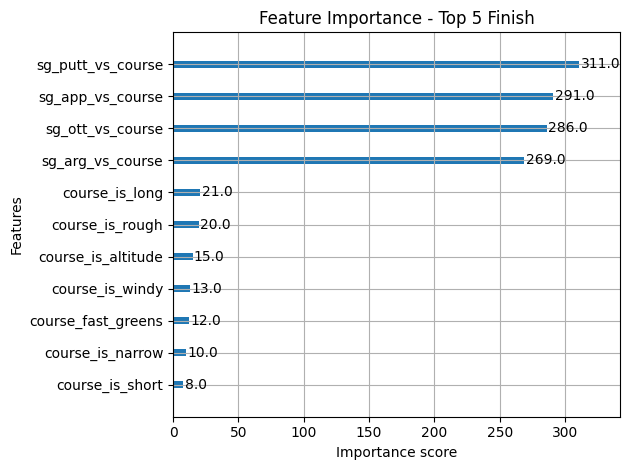

<Figure size 800x600 with 0 Axes>

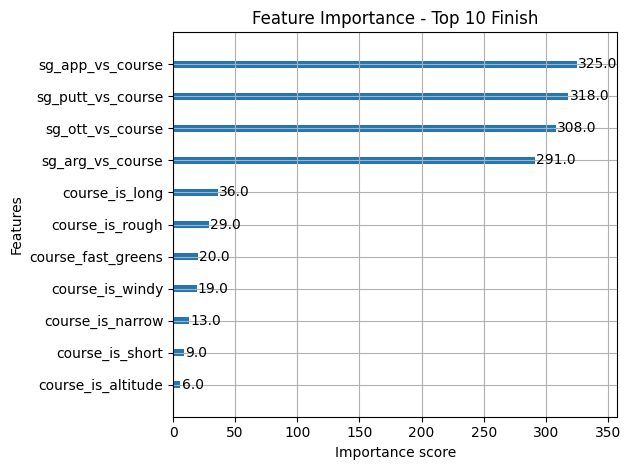

<Figure size 800x600 with 0 Axes>

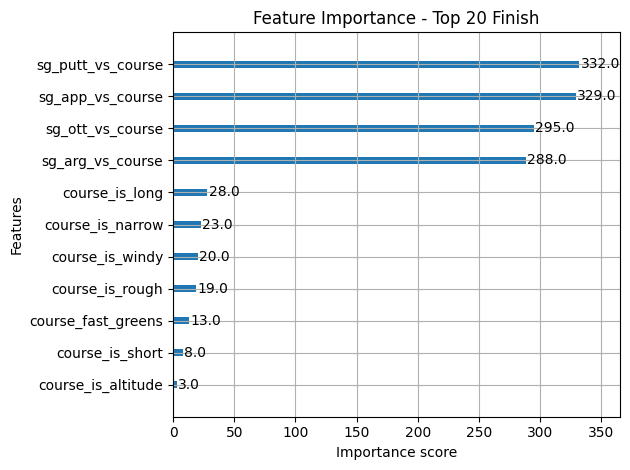

In [91]:
# MODEL FEATURE IMPORTANCE
from xgboost import plot_importance

# Plot for Top 5
plt.figure(figsize=(8, 6))
plot_importance(model_top5, importance_type='weight', title='Feature Importance - Top 5 Finish')
plt.tight_layout()  # Fix layout overlap
plt.savefig("feature_importance_top5_official.png", dpi=300, bbox_inches='tight')
plt.show()

# Plot for Top 10
plt.figure(figsize=(8, 6))
plot_importance(model_top10, importance_type='weight', title='Feature Importance - Top 10 Finish')
plt.tight_layout()  # Fix layout overlap
plt.savefig("feature_importance_top10_official.png", dpi=300, bbox_inches='tight')
plt.show()

# Plot for Top 20
plt.figure(figsize=(8, 6))
plot_importance(model_top20, importance_type='weight', title='Feature Importance - Top 20 Finish')
plt.tight_layout()  # Fix layout overlap
plt.savefig("feature_importance_top20_official.png", dpi=300, bbox_inches='tight')
plt.show()